In [42]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem
import seaborn as sns
import pickle

In [41]:
def binarize(traces):
    stds = np.std(traces,axis=-1)
    out = np.zeros_like(traces)
    for i in range(traces.shape[0]):
        for j in range(traces.shape[1]):
            if traces[i,j]>stds[i]:
                out[i][j] = 1
            else:
                out[i][j] = 0

    return out


def BIC(ll,k,n):
    return k*np.log(n) + 2*ll


In [29]:
data = np.load('../../../data/raw_data/nike_calcium_trace.npy')
X = binarize(data).T
behaviour = pickle.load()

In [31]:
components = np.arange(1,21)
n_splits = 10
models = []
median_ll = []
bic = []
for i in tqdm(components):
    kf = KFold(n_splits=n_splits)
    boot_models = []
    boot_median_ll = []
    boot_bic = []
    # k fold cross validation, saves best model
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        model = BernoulliRBM(n_components=i)
        model.fit(X_train)
        boot_models.append(model)
        scored_samples = model.score_samples(X_test)
        # compute BIC
        ll = np.median(scored_samples)
        n = len(test_index)
        
        k = np.prod(model.components_.shape) +len(model.intercept_hidden_)+ len(model.intercept_visible_)
        boot_bic.append(BIC(ll,k,n))
        boot_median_ll.append(ll)

    median_ll.append(boot_median_ll)
    bic.append(boot_bic)
    models.append(boot_models[np.argmax(boot_median_ll)])

median_ll = np.asarray(median_ll)


100%|██████████| 20/20 [30:51<00:00, 92.58s/it] 


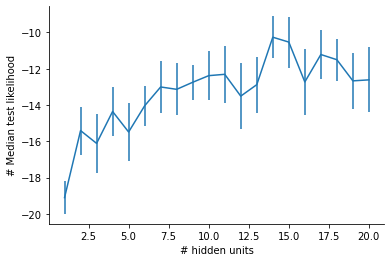

In [32]:
plt.errorbar(components,np.mean(median_ll,axis=1),yerr=sem(median_ll,axis=1))
#plt.errorbar(components,np.mean(bic,axis=1),yerr=sem(bic,axis=1))

plt.xlabel('# hidden units')
plt.ylabel('# Median test likelihood')
sns.despine()

In [37]:
best_model = models[15]

<AxesSubplot:>

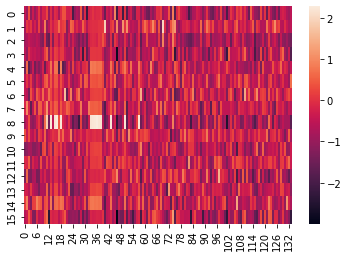

In [38]:
sns.heatmap(best_model.components_)

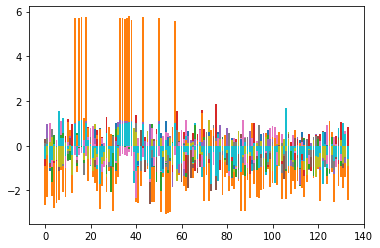

In [39]:
component_w = models[-1].components_
for i,w in enumerate(component_w):
    plt.bar(np.arange(len(w)),w)

## Stimulus classification using RBMs

In [ ]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 20
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)


from sklearn import metrics

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)




